# Prediction

Classification models implement tools for prediction, to get both probabilities (`predict_proba`) and label (`predict`). Both derive the prediction based on the ensemble of local models.

1. For a new location on which you want a prediction, identify local models with a bandwidth used to train the model.
2. Apply the kernel function used to train the model to derive weights of each of the local models.
3. Make prediction using each of the local models in the bandwidth.
4. Make weighted average of prediction based on the kernel weights.
5. Normalize the result to ensure sum of probabilities is 1.

See that in action:

In [1]:
import geopandas as gpd
from geodatasets import get_path
from sklearn import metrics
from sklearn.model_selection import train_test_split

from gwlearn.ensemble import GWRandomForestClassifier

Get sample data

In [2]:
gdf = gpd.read_file(get_path("geoda.ncovr")).to_crs(5070)

gdf['point'] = gdf.representative_point()
gdf = gdf.set_geometry('point')

y = gdf["FH90"] > gdf["FH90"].median()
X = gdf.iloc[:, 9:15]

Leave out some locations for prediction later.

In [3]:
X_train, X_test, y_train, y_test, geom_train, geom_test = train_test_split(X, y, gdf.geometry, test_size=.1)

Fit the model using the training subset. If you plan to do the prediction, you need to store the local models, which is False by default. When set to True, all the models are kept in memory, so be careful with large datasets. If given a path, all the models will be stored on disk instead, freeing the memory load.

In [4]:
gwrf = GWRandomForestClassifier(
    geometry=geom_train,
    bandwidth=250,
    fixed=False,
    keep_models=True,
)
gwrf.fit(
    X_train,
    y_train,
)

GWRandomForestClassifier(bandwidth=250,
                         geometry=1989    POINT (-384564.533 1369397.395)
2659        POINT (82854.77 892472.294)
275     POINT (1778051.919 2632546.856)
1967    POINT (1004467.569 1443277.098)
902      POINT (723688.803 1954767.539)
                     ...               
939     POINT (1472608.546 2016499.638)
1433     POINT (575941.177 1692254.138)
2754     POINT (-231950.603 796277.137)
1309      POINT (387282.83 1733563.097)
942     POINT (1651190.784 2062911.326)
Name: point, Length: 2776, dtype: geometry,
                         keep_models=True)

Now, you can use the test subset to get the prediction. Note that given the prediction is pulled from an ensemble of local models, it is not particularly performant. However, it shall be spatially robust.

In [5]:
proba = gwrf.predict_proba(X_test, geometry=geom_test)
proba

False     True 
805   0.811815  0.188185
1704  0.096184  0.903816
2872  0.833818  0.166182
394   0.350391  0.649609
2569  0.053624  0.946376
...        ...       ...
2231  0.077666  0.922334
2682  0.251958  0.748042
1263  0.992466  0.007534
2782  0.103060  0.896940
2352  0.135677  0.864323

[309 rows x 2 columns]

You can then check the accuracy of this prediction. Note that similarly to fitting, there might be locations that return NA, if all of the local models within its bandwidth are not fitted.

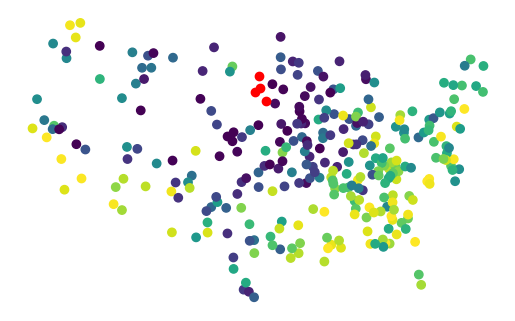

In [6]:
gpd.GeoDataFrame(proba, geometry=geom_test).plot(True, missing_kwds=dict(color='red')).set_axis_off()

That one red dot, is in the middle of unfittable area.

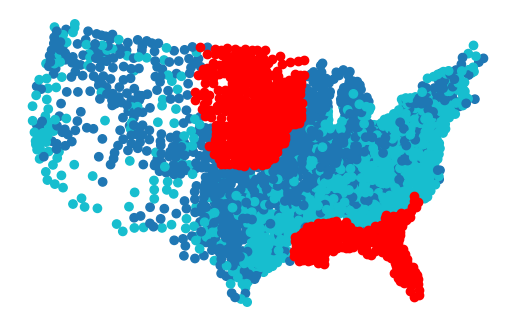

In [7]:
geom_train.to_frame().plot(gwrf.pred_, missing_kwds=dict(color='red')).set_axis_off()

Filter it out and measure the performance on the left-out sample.

In [8]:
na_mask = proba.isna().any(axis=1)

pred = proba[~na_mask].idxmax(axis=1).astype(bool)

metrics.accuracy_score(y_test[~na_mask], pred)

0.819672131147541